# High-Ram Validation

In [ ]:
import psutil

ram_gb = psutil.virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


If the execution result of running the code cell below is "Not using a high-RAM runtime", then you can enable a high-RAM runtime via `Runtime > Change runtime type` in the menu. Then select High-RAM in the Runtime shape toggle button. After, re-execute the code cell.

# Lectura CSV

In [ ]:
import pandas as pd
df_spy = pd.read_csv('spy_options_call_output_all.csv')

In [ ]:
# Seleccionar solo OTM
df_spy = df_spy[df_spy['moneyness_category'] == 'OTM']

In [ ]:
# Ordenar cronológicamente el dataset
df_spy = df_spy.sort_values(by=['quote_date', 'expire_date'], ascending=True).reset_index(drop=True)

In [ ]:
# Verificar si esta ordenado correctamente
print(df_spy['quote_date'].head())
print(df_spy['quote_date'].tail())

0    2020-01-02
1    2020-01-02
2    2020-01-02
3    2020-01-02
4    2020-01-02
Name: quote_date, dtype: object
61639    2023-12-28
61640    2023-12-28
61641    2023-12-28
61642    2023-12-28
61643    2023-12-29
Name: quote_date, dtype: object


In [ ]:
df_spy.head()

,quote_date,expire_date,dte,underlying_last,strike,strike_distance,strike_distance_pct,c_last,c_bid,c_ask,...,relative_spread,dte_year,c_volume_log,c_volume_log_scaled,volume_zero,moneyness,iv_pct_rank,c_iv_min,iv_skew,spread_mid_price
0,2020-01-02,2020-01-03,1.0,324.87,331.5,6.6,0.020,0.05,0.0,0.02,...,2.0,0.003968,2.708050,0.396255,0,0.980000,0.615385,0.07086,0.03798,2.0
1,2020-01-02,2020-01-03,1.0,324.87,332.0,7.1,0.022,0.01,0.0,0.02,...,2.0,0.003968,1.945910,0.284735,0,0.978524,0.628205,0.07086,0.04462,2.0
2,2020-01-02,2020-01-03,1.0,324.87,332.5,7.6,0.023,0.02,0.0,0.02,...,2.0,0.003968,3.688879,0.539775,0,0.977053,0.692308,0.07086,0.05172,2.0
3,2020-01-02,2020-01-03,1.0,324.87,336.0,11.1,0.034,0.03,0.0,0.02,...,2.0,0.003968,4.304065,0.629792,0,0.966875,0.846154,0.07086,0.10017,2.0
4,2020-01-02,2020-01-03,1.0,324.87,340.0,15.1,0.047,0.01,0.0,0.02,...,2.0,0.003968,0.693147,0.101425,0,0.955500,0.910256,0.07086,0.15350,2.0


In [ ]:
df_spy.shape

(61644, 31)

# Features

In [ ]:
df_spy.groupby('anio').size()

,0
anio,
2020,8552
2021,11582
2022,22410
2023,19100


In [ ]:
# Test data
df_spy_2023 = df_spy[df_spy['anio'] == 2023]

In [ ]:
# Train data
df_spy = df_spy[df_spy['anio'] < 2023]

In [ ]:
# target_train = 'c_mid_price'
# target_test = 'c_last'
# MAE: 0.6235434835084429
# RMSE: 2.648048019022547
# R²: 0.9926071365933151

features_cols = [
                 # Variables Black Scholes (captura el comportamiento teorico del precio de la opcion)
                 'moneyness', # contiene a 'underlying_last' y 'strike'
                 'dte_year',
                 'c_iv',
                  # Variables que capturan micro-comportamientos del precio real de la opcion (utilizando 'c_mid_price' en periodo de entrenamiento)
                 'iv_skew',
                 'iv_pct_rank',
                 'c_volume_log_scaled', # volumen y liquidez
                 # Indicadores Greeks (aportan estructura del modelo BS)
                 'c_delta',
                 'c_gamma',
                 'c_vega',
                 'c_theta'
                  ]

Manten tu esquema:
- target_train = c_mid_price (mas estable al momento de entrenar)
- target_test = c_last (testear con valores reales del mercado)

Ese esquema es excelente y es exactamente lo que usan:
- market makers
- modelos basados en BS/Heston
- desk de volatilidad

In [ ]:
# target_train = 'c_last' # Para predecir el precio real transado de una opcion (Hacer un modelo robusto a mercado real, existe mucho mas ruido del mercado)
target_train = 'c_mid_price' # Para predecir (modelar) el precio teorico justo o replicar Black-Scholes
target_test = 'c_last'

In [ ]:
X = df_spy[features_cols]
y = df_spy[target_train]

In [ ]:
X_test_2023 = df_spy_2023[features_cols]
y_test_2023 = df_spy_2023[target_test]

In [ ]:
X.dtypes

,0
moneyness,float64
dte_year,float64
c_iv,float64
iv_skew,float64
iv_pct_rank,float64
c_volume_log_scaled,float64
c_delta,float64
c_gamma,float64
c_vega,float64
c_theta,float64


In [ ]:
X.describe()

,moneyness,dte_year,c_iv,iv_skew,iv_pct_rank,c_volume_log_scaled,c_delta,c_gamma,c_vega,c_theta
count,42544.000000,42544.000000,42544.000000,42544.000000,42544.000000,42544.000000,42544.000000,42544.000000,42544.000000,42544.000000
mean,0.948687,0.016419,0.253600,0.039437,0.211613,0.593682,0.089908,0.019174,0.054415,-0.105459
std,0.051679,0.009590,0.200360,0.192042,0.184446,0.236086,0.131893,0.042988,0.065635,0.156076
min,0.564118,0.000000,0.014980,-1.086930,0.001412,0.000000,0.000110,0.000000,0.000000,-0.999080
25%,0.933674,0.007937,0.141908,-0.026992,0.081023,0.443158,0.005500,0.001650,0.006800,-0.141407
50%,0.962751,0.015873,0.206040,0.016630,0.156639,0.628424,0.018705,0.006245,0.020270,-0.027415
75%,0.982500,0.023810,0.284795,0.105692,0.281737,0.768377,0.122847,0.024930,0.088432,-0.010570
max,0.999979,0.031905,2.974060,2.722760,1.000000,1.000000,0.554450,1.201350,0.296370,-0.002000


In [ ]:
print(df_spy['moneyness_category'].value_counts())
print(df_spy['moneyness_category'].value_counts(normalize=True)*100)

moneyness_category
OTM    42544
Name: count, dtype: int64
moneyness_category
OTM    100.0
Name: proportion, dtype: float64


In [ ]:
y.describe()

,c_mid_price
count,42544.000000
mean,0.493763
std,1.000880
min,0.010000
25%,0.015000
50%,0.050000
75%,0.425000
max,14.400000


In [ ]:
print("cantidad features:", X.shape[1])
print("cantidad target:", len(y.shape))

cantidad features: 10
cantidad target: 1


In [ ]:
X.dtypes

,0
moneyness,float64
dte_year,float64
c_iv,float64
iv_skew,float64
iv_pct_rank,float64
c_volume_log_scaled,float64
c_delta,float64
c_gamma,float64
c_vega,float64
c_theta,float64


# XGBoost

In [ ]:
import time
import numpy as np
import pandas as pd

import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

## Entrenamiento

In [ ]:
# Split data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X
y_train = y

# transformamos el target con log1p
y_train_log = np.log1p(y_train)

In [ ]:
y_train.describe()

,c_mid_price
count,42544.000000
mean,0.493763
std,1.000880
min,0.010000
25%,0.015000
50%,0.050000
75%,0.425000
max,14.400000


In [ ]:
y_train_log.describe()

,c_mid_price
count,42544.000000
mean,0.278289
std,0.433027
min,0.009950
25%,0.014889
50%,0.048790
75%,0.354172
max,2.734368


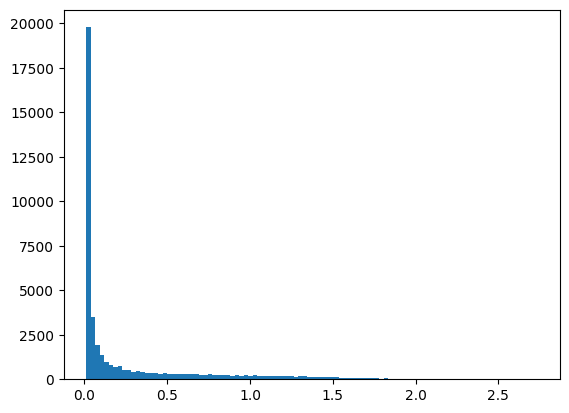

In [ ]:
import matplotlib.pyplot as plt
plt.hist(y_train_log, bins=100);

In [ ]:
print(f"Cantidad Registros para X_train: {X_train.shape[0]}")

Cantidad Registros para X_train: 42544


In [ ]:
print(f"Cantidad Registros para X_test_2023: {X_test_2023.shape[0]}")

Cantidad Registros para X_test_2023: 19100


## Optimizacion (Hyperparameter Tuning)

### RandomizedSearchCV

RandomizedSearchCV es Rapida y para Exploración inicial. Para encontrar los parametros optimos iniciales.




In [ ]:
# Definir modelo base
xgb_model = xgb.XGBRegressor(
    objective="reg:squarederror",
    tree_method="hist",   # más rápido
    n_estimators=500,
    random_state=42
)

In [ ]:
# Indispensable para datos con temporalidad: (TimeSeriesSplit)
cv = TimeSeriesSplit(n_splits=5) #El dataset tiene que estar ordenado de manera cronologica (puede ser ascendentemente)

In [ ]:
start_time = time.time()

# Definimos el espacio de búsqueda de los hypermarameters
param_distributions = {
    "max_depth": [3, 4, 5, 6, 7, 8],
    "learning_rate": np.linspace(0.01, 0.3, 20),
    "subsample": np.linspace(0.5, 1.0, 6),
    "colsample_bytree": np.linspace(0.5, 1.0, 6),
    "gamma": [0, 0.1, 0.2, 0.5, 1],
    "min_child_weight": [1, 3, 5, 7, 10],
    "n_estimators": [300, 500, 700, 1000]
}

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions,
    n_iter=30, # número de combinaciones aleatorias que se probaran. Elige aleatoriamente 30 combinaciones de las (6*3*3*3*5*5*4 = 16200 combinaciones definidas en param_dist)
    scoring="neg_mean_absolute_error",
    cv=cv, # Cross Validation. Cantidad de folds (particiones del mismo tamaño). Para cada combinacion de hiperparametros el modelo entrena con 2 folds (~66% de los datos) y evalúa en el fold restante (~33%). Repite esto 3 veces, cambiando cuál fold es el de validación cada vez.
    verbose=1, #2: Muestra el progreso del entrenamiento para cada modelo. 1: Te da solo el mensaje general.
    random_state=42,
    n_jobs=-1 # -1: usa todos los núcleos del CPU
)

random_search.fit(X_train, y_train_log)

end_time = time.time()
print(f"RandomizedSearchCV Searching time: {end_time - start_time} seconds")

Fitting 5 folds for each of 30 candidates, totalling 150 fits
RandomizedSearchCV Searching time: 108.75892782211304 seconds


In [ ]:
print(f"RandomizedSearchCV Searching time: {(end_time - start_time)/60} minutes")

RandomizedSearchCV Searching time: 1.8126487970352172 minutes


Vamos a desglosar los parámetros utilizados en la celda de `RandomizedSearchCV`:

**`param_dist` (Distribución de Parámetros):** Este diccionario define los rangos o listas de valores de hiperparámetros de los cuales `RandomizedSearchCV` tomará muestras aleatoriamente.

*   `n_estimators`: El número de árboles en el bosque. Un número mayor generalmente mejora el rendimiento pero aumenta el tiempo de cálculo. Estamos muestreando de [100, 200, 500].
*   `max_depth`: La profundidad máxima de cada árbol. `None` significa que los nodos se expanden hasta que todas las hojas son puras o hasta que todas las hojas contienen menos muestras que `min_samples_split`. Muestreo de [5, 10, 20, None].
*   `min_samples_split`: El número mínimo de muestras requeridas para dividir un nodo interno. Muestreo de [2, 5, 10].
*   `min_samples_leaf`: El número mínimo de muestras requeridas para estar en un nodo hoja. Muestreo de [1, 2, 4].
*   `max_features`: El número de características a considerar al buscar la mejor división.
    *   `'auto'` (o `'sqrt'` en versiones más recientes): Considera `sqrt(n_features)` características.
    *   `'log2'`: Considera `log2(n_features)` características.
    *   Estamos muestreando de ['auto', 'sqrt', 'log2'].

**Parámetros de Inicialización de `RandomizedSearchCV`:**

*   `estimator`: El objeto del modelo (en este caso, `rf`, un `RandomForestRegressor`) para el cual desea ajustar los hiperparámetros.
*   `param_distributions`: El diccionario que define el espacio de parámetros para muestrear (el `param_dist` que acabamos de discutir).
*   `n_iter`: El número de configuraciones de parámetros que se muestrean. Valores más altos significan que se prueban más combinaciones, lo que potencialmente lleva a mejores resultados pero tarda más tiempo. Aquí, se muestrean 30 combinaciones.
*   `cv`: Determina la estrategia de división de validación cruzada. `cv=3` significa que se utiliza validación cruzada de 3 pliegues.
*   `verbose`: Controla la verbosidad de la salida. `verbose=2` proporciona un nivel moderado de detalle durante la búsqueda.
*   `random_state`: Controla la aleatoriedad del muestreo. Establecer un número específico garantiza la reproducibilidad.
*   `n_jobs`: El número de trabajos a ejecutar en paralelo. `-1` significa usar todos los procesadores disponibles.

## Entrenar modelo con los mejores hiperparametros

In [ ]:
# XGBRegressor(subsample = 1.0,
#              n_estimators = 500,
#              min_child_weight = 10,
#              max_depth = 8,
#              learning_rate = 0.05578,
#              gamma = 0,
#              colsample_bytree = 0.7,
#              random_state = 42
#             )

In [ ]:
random_search.best_params_

{'subsample': np.float64(1.0),
 'n_estimators': 500,
 'min_child_weight': 10,
 'max_depth': 8,
 'learning_rate': np.float64(0.05578947368421053),
 'gamma': 0,
 'colsample_bytree': np.float64(0.7)}

- Mejores hiperparametros (estatico):<br>
{'subsample': np.float64(1.0),
 'n_estimators': 500,
 'min_child_weight': 10,
 'max_depth': 8,
 'learning_rate': np.float64(0.05578947368421053),
 'gamma': 0,
 'colsample_bytree': np.float64(0.7)}

In [ ]:
# Entrenar modelo final con los mejores hiperparámetros
start_time = time.time()

best_model = random_search.best_estimator_
best_model.fit(X_train, y_train_log)

end_time = time.time()
print(f"BestModel Training time: {end_time - start_time} seconds")

BestModel Training time: 6.5683207511901855 seconds


In [ ]:
print(f"BestModel Training time: {(end_time - start_time)/60} minutes")

BestModel Training time: 0.10947201251983643 minutes


### GridSearchCV

GridSearchCV es Lenta, para ajuste fino final. Para encontrar los parametros optimos finales.


In [ ]:
# param_grid = {
#     'n_estimators': [200, 400, 800],
#     'max_depth': [10, 20, None],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['auto', 'sqrt']
# }

# grid_search = GridSearchCV(
#     estimator=RandomForestRegressor(random_state=42, n_jobs=-1),
#     param_grid=param_grid,
#     cv=3,
#     scoring='neg_root_mean_squared_error',
#     verbose=1,
#     n_jobs=-1
# )

# grid_search.fit(X_train, y_train)

# print("Mejores parámetros:", grid_search.best_params_)
# best_model = grid_search.best_estimator_

## Backtesting

### Total

In [ ]:
start_time = time.time()

y_pred_log_best = best_model.predict(X_test_2023)

end_time = time.time()
print(f"Backtesting time: {end_time - start_time} seconds")

Backtesting time: 0.3606534004211426 seconds


In [ ]:
# Destransformar predicciones
y_pred_best = np.expm1(y_pred_log_best)

In [ ]:
print("MAE:", mean_absolute_error(y_test_2023, y_pred_best))
print("RMSE:", mean_squared_error(y_test_2023, y_pred_best))
print("R²:", r2_score(y_test_2023, y_pred_best))

MAE: 0.019752208312390204
RMSE: 0.0014427053685161248
R²: 0.9978040775135756


### Grafico Real vs Prediccion

In [ ]:
# Ensure quote_date is datetime type
df_spy_2023['quote_date'] = pd.to_datetime(df_spy_2023['quote_date'])

# Sort the test data by date to ensure proper time series plotting
df_spy_2023_sorted = df_spy_2023.sort_values(by='quote_date').reset_index(drop=True)
y_test_2023_sorted = df_spy_2023_sorted[target_test]
X_test_2023_sorted = df_spy_2023_sorted[features_cols]

y_pred_log_best_sorted = best_model.predict(X_test_2023_sorted)
y_pred_best_sorted = np.expm1(y_pred_log_best_sorted)

In [ ]:
df_spy_2023_sorted['c_last_predict'] = y_pred_best_sorted
df_spy_2023_sorted['month'] = df_spy_2023_sorted['quote_date'].dt.month

In [ ]:
df_real_prices = df_spy_2023_sorted.groupby('month')['c_last'].mean()
df_pred_prices = df_spy_2023_sorted.groupby('month')['c_last_predict'].mean()

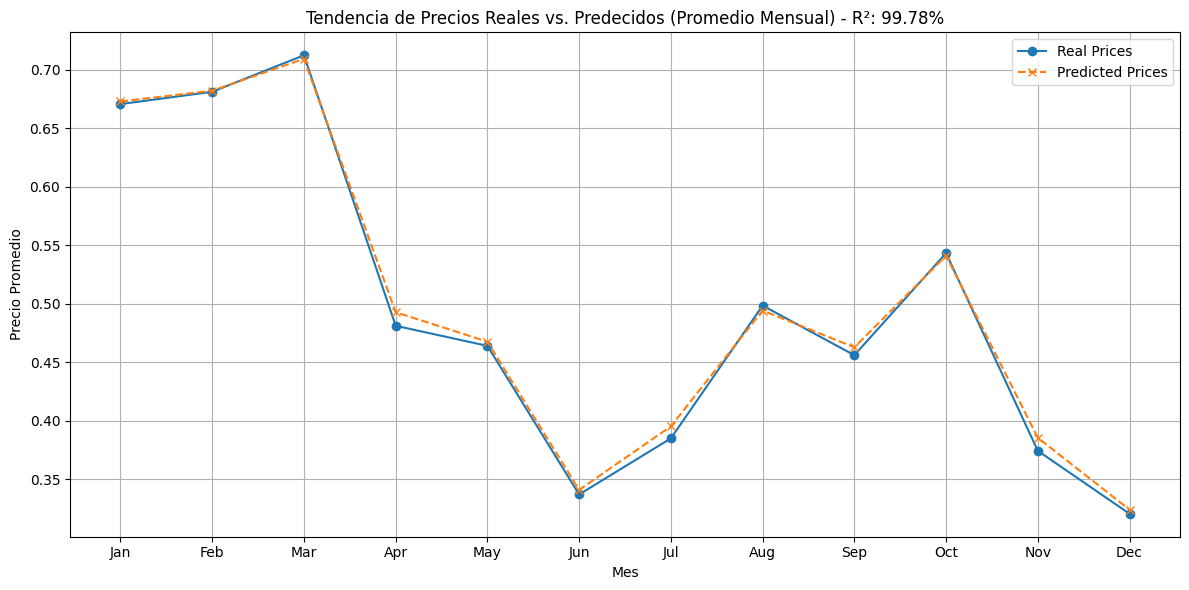

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df_real_prices.index, df_real_prices.values, label='Real Prices', marker='o', linestyle='-')
plt.plot(df_pred_prices.index, df_pred_prices.values, label='Predicted Prices', marker='x', linestyle='--')

plt.title('Tendencia de Precios Reales vs. Predecidos (Promedio Mensual) - R²: 99.78%')
plt.xlabel('Mes')
plt.ylabel('Precio Promedio')
plt.xticks(ticks=df_real_prices.index, labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Por Q

In [ ]:
#Dar formato fecha
df_spy_2023['quote_date'] = pd.to_datetime(df_spy_2023['quote_date'])

In [ ]:
quarters = [(1, 3), (4, 6), (7, 9), (10, 12)]
q = 1
for quarter in quarters:
    start_month, end_month = quarter
    conditions = (
        (df_spy_2023['quote_date'].dt.year == 2023) &
        ((df_spy_2023['quote_date'].dt.month >= start_month) & (df_spy_2023['quote_date'].dt.month <= end_month))
    )
    df_spy_2023_q = df_spy_2023[conditions]

    X_test_2023_q = df_spy_2023_q[features_cols]
    y_test_2023_q = df_spy_2023_q[target_test]

    y_pred_log_best_q = best_model.predict(X_test_2023_q)

    # Destransformar predicciones
    y_pred_best_q = np.expm1(y_pred_log_best_q)

    print(f"***** Backtesting Q{q} *****")
    print("MAE:", mean_absolute_error(y_test_2023_q, y_pred_best_q))
    print("RMSE:", mean_squared_error(y_test_2023_q, y_pred_best_q))
    print("R²:", r2_score(y_test_2023_q, y_pred_best_q))
    print()
    q += 1

***** Backtesting Q1 *****
MAE: 0.02092874744721753
RMSE: 0.001685291343013193
R²: 0.9983642495690404

***** Backtesting Q2 *****
MAE: 0.017162173173226342
RMSE: 0.0009743234653082128
R²: 0.9977378244580231

***** Backtesting Q3 *****
MAE: 0.020454933935057564
RMSE: 0.0015516958723762134
R²: 0.996879825607752

***** Backtesting Q4 *****
MAE: 0.019976737133966315
RMSE: 0.0014653922503037049
R²: 0.9971499255573337



### Por Mes

In [ ]:
m = 1
for month in range(1, 13):
    conditions = (
        (df_spy_2023['quote_date'].dt.year == 2023) &
        (df_spy_2023['quote_date'].dt.month == month)
    )
    df_spy_2023_m = df_spy_2023[conditions]

    X_test_2023_m = df_spy_2023_m[features_cols]
    y_test_2023_m = df_spy_2023_m[target_test]

    y_pred_log_best_m = best_model.predict(X_test_2023_m)

    # Destransformar predicciones
    y_pred_best_m = np.expm1(y_pred_log_best_m)

    print(f"***** Backtesting Mes {m} *****")
    print("MAE:", mean_absolute_error(y_test_2023_m, y_pred_best_m))
    print("RMSE:", mean_squared_error(y_test_2023_m, y_pred_best_m))
    print("R²:", r2_score(y_test_2023_m, y_pred_best_m))
    print()
    m += 1

***** Backtesting Mes 1 *****
MAE: 0.018421780960767544
RMSE: 0.0010775062743589876
R²: 0.9989090085579075

***** Backtesting Mes 2 *****
MAE: 0.01955200334853824
RMSE: 0.0013698120126092376
R²: 0.9985232159900801

***** Backtesting Mes 3 *****
MAE: 0.024014932921590706
RMSE: 0.002420131901109988
R²: 0.9978768266106061

***** Backtesting Mes 4 *****
MAE: 0.018688879475548217
RMSE: 0.001179712084518985
R²: 0.9976153859477087

***** Backtesting Mes 5 *****
MAE: 0.01639944646541836
RMSE: 0.0008929794354404056
R²: 0.998263005234493

***** Backtesting Mes 6 *****
MAE: 0.016771381040693735
RMSE: 0.0009006092436307332
R²: 0.996873053878474

***** Backtesting Mes 7 *****
MAE: 0.0202075617158142
RMSE: 0.0014669276563201953
R²: 0.9959130470395972

***** Backtesting Mes 8 *****
MAE: 0.022014610482412475
RMSE: 0.0019189660869612802
R²: 0.9967957469951765

***** Backtesting Mes 9 *****
MAE: 0.018758436984413963
RMSE: 0.0011778123245568403
R²: 0.9976343003245418

***** Backtesting Mes 10 *****
MAE: 

## Graficas

In [ ]:
importances = pd.Series(best_model.feature_importances_, index=X.columns)
importances.sort_values(ascending=False)

,0
c_delta,0.591908
c_vega,0.163664
c_theta,0.124012
c_gamma,0.059065
dte_year,0.034152
c_iv,0.013808
moneyness,0.008840
iv_pct_rank,0.004196
iv_skew,0.000185
c_volume_log_scaled,0.000169


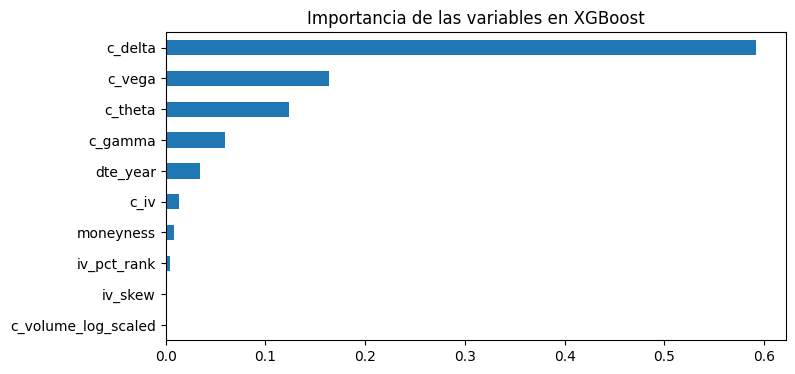

In [ ]:
import matplotlib.pyplot as plt

importances = pd.Series(best_model.feature_importances_, index=X.columns)
importances.sort_values(ascending=True).plot(kind='barh', figsize=(8, 4))
plt.title("Importancia de las variables en XGBoost")
plt.show()

## Conclusiones

- R² ≈ 99.78% → el modelo generaliza bastante bien.
- La variable con mayor importancia en el modelo es c_delta que mide la sensibilidad del precio de la opcion respecto al activo subyacente (en este caso el precio del SPY).
- Las variables griegas capturan los micro-comportamientos del precio de la opcion.
- Las relaciones en 2023 siguen el comportamiento historico de los 3 ultimos años, el modelo se adapta bien.

**Los resultados del modelo:**
- MAE ≈ 0.0197
  - Esto significa que en promedio el modelo se equivoca solo 1.97 dólares por contrato (≈ 2 centavos por prima), lo cual es muy bueno en regiones OTM, donde los precios son muy pequeños.
- RMSE ≈ 0.9978
- R² ≈ 0.9978
  - Esto indica que el modelo explica casi toda la variabilidad del precio.

**Importancia de variables**
- **c_delta (59%):** OTM → Delta es extremadamente informativo. La opción es casi un proxy lineal de Delta.
- **c_vega, c_theta, c_gamma:** En OTM, todo el valor es temporal → greeks dominan.
- **dte_year:** Las OTM son muy sensibles al tiempo restante.
- **c_iv:** El IV manda el precio de OTM, porque su valor intrínseco es 0.
- **moneyness:** Afecta el nivel relativo.
- **iv_pct_rank, iv_skew, volumen:** Microruidos del mercado, pero aportan poco en OTM.


**Conclusiones**
- Esto es EXACTAMENTE lo que un modelo bien calibrado debería mostrar.
- El modelo explica casi toda la variabilidad del precio y es muy eficiente al momento de determinar el precio real de una opcion.

In [ ]:
# Finished!